# Data Cleaning - Players Teams

In [16]:
import pandas as pd
from utils import *
import os

df = pd.read_csv('../data/raw/players_teams.csv')

init_num_rows = df.shape[0]

print(f"Num rows: {df.shape[0]}")
print(f"Num cols: {df.shape[1]}")

df.head()

Num rows: 1876
Num cols: 43


,playerID,year,stint,tmID,lgID,GP,GS,minutes,points,oRebounds,...,PostBlocks,PostTurnovers,PostPF,PostfgAttempted,PostfgMade,PostftAttempted,PostftMade,PostthreeAttempted,PostthreeMade,PostDQ
0,abrossv01w,2,0,MIN,WNBA,26,23,846,343,43,...,0,0,0,0,0,0,0,0,0,0
1,abrossv01w,3,0,MIN,WNBA,27,27,805,314,45,...,0,0,0,0,0,0,0,0,0,0
2,abrossv01w,4,0,MIN,WNBA,30,25,792,318,44,...,1,8,8,22,6,8,8,7,3,0
3,abrossv01w,5,0,MIN,WNBA,22,11,462,146,17,...,2,3,7,23,8,4,2,8,2,0
4,abrossv01w,6,0,MIN,WNBA,31,31,777,304,29,...,0,0,0,0,0,0,0,0,0,0


## Dealing with Missing Values / Features

<Axes: title={'center': 'Number of null values per column'}>

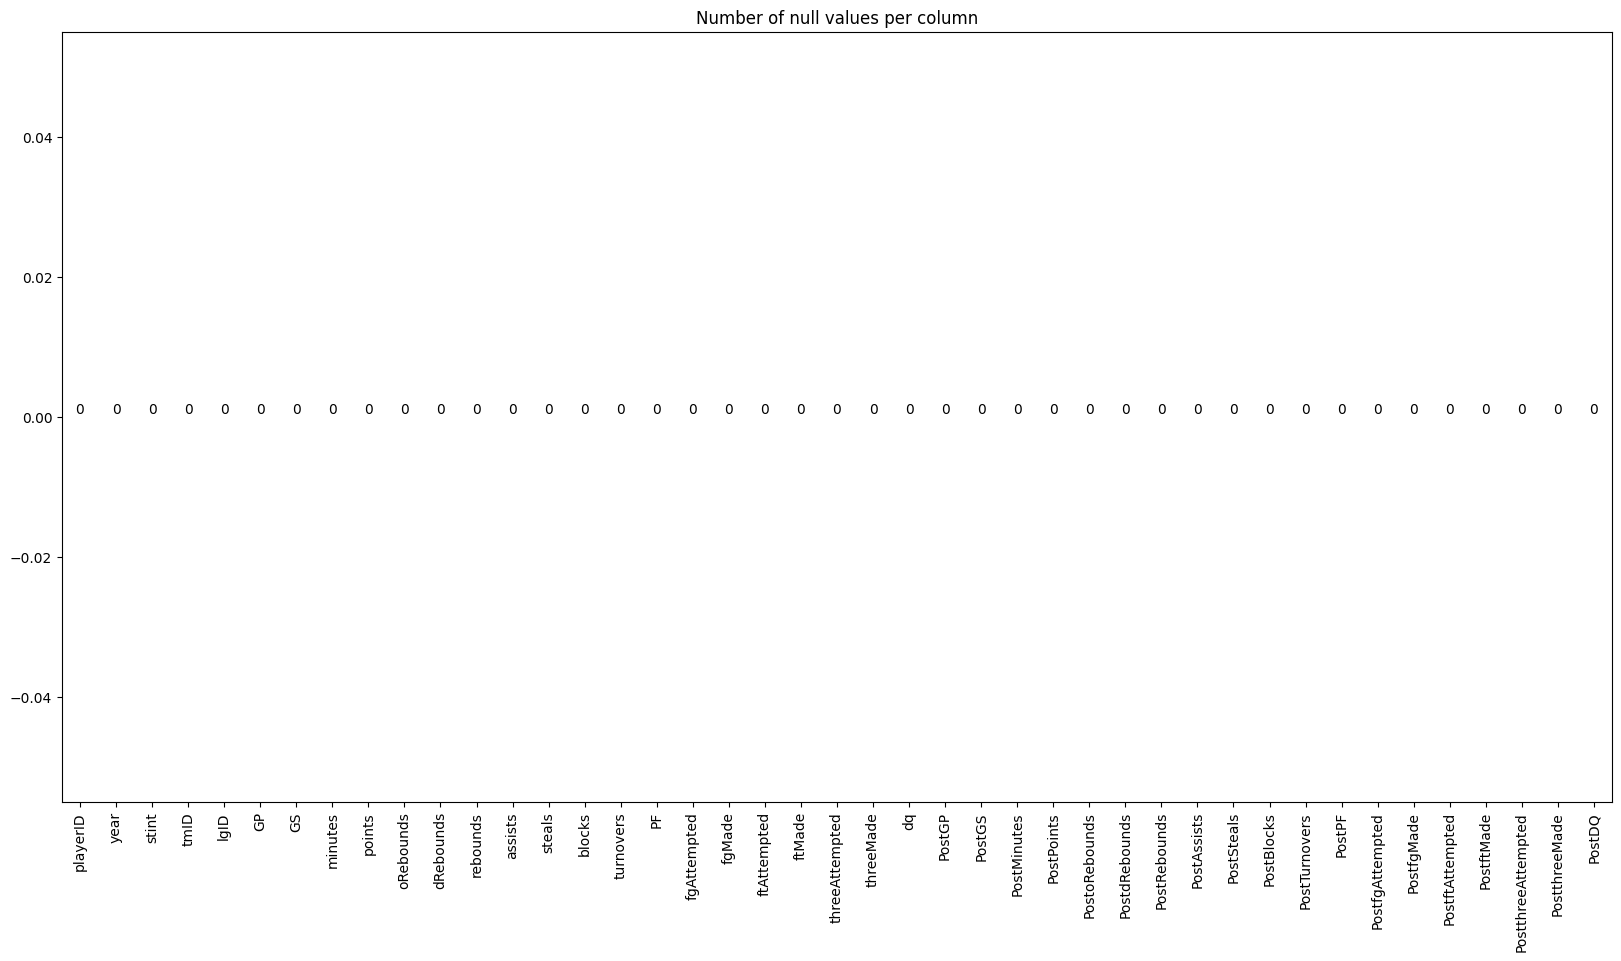

In [17]:
nulls_values_by_column(df, (20, 10))

## Dealing with Duplicate values / Redundant Data

<Axes: title={'center': 'Number of Unique Values Per Column'}>

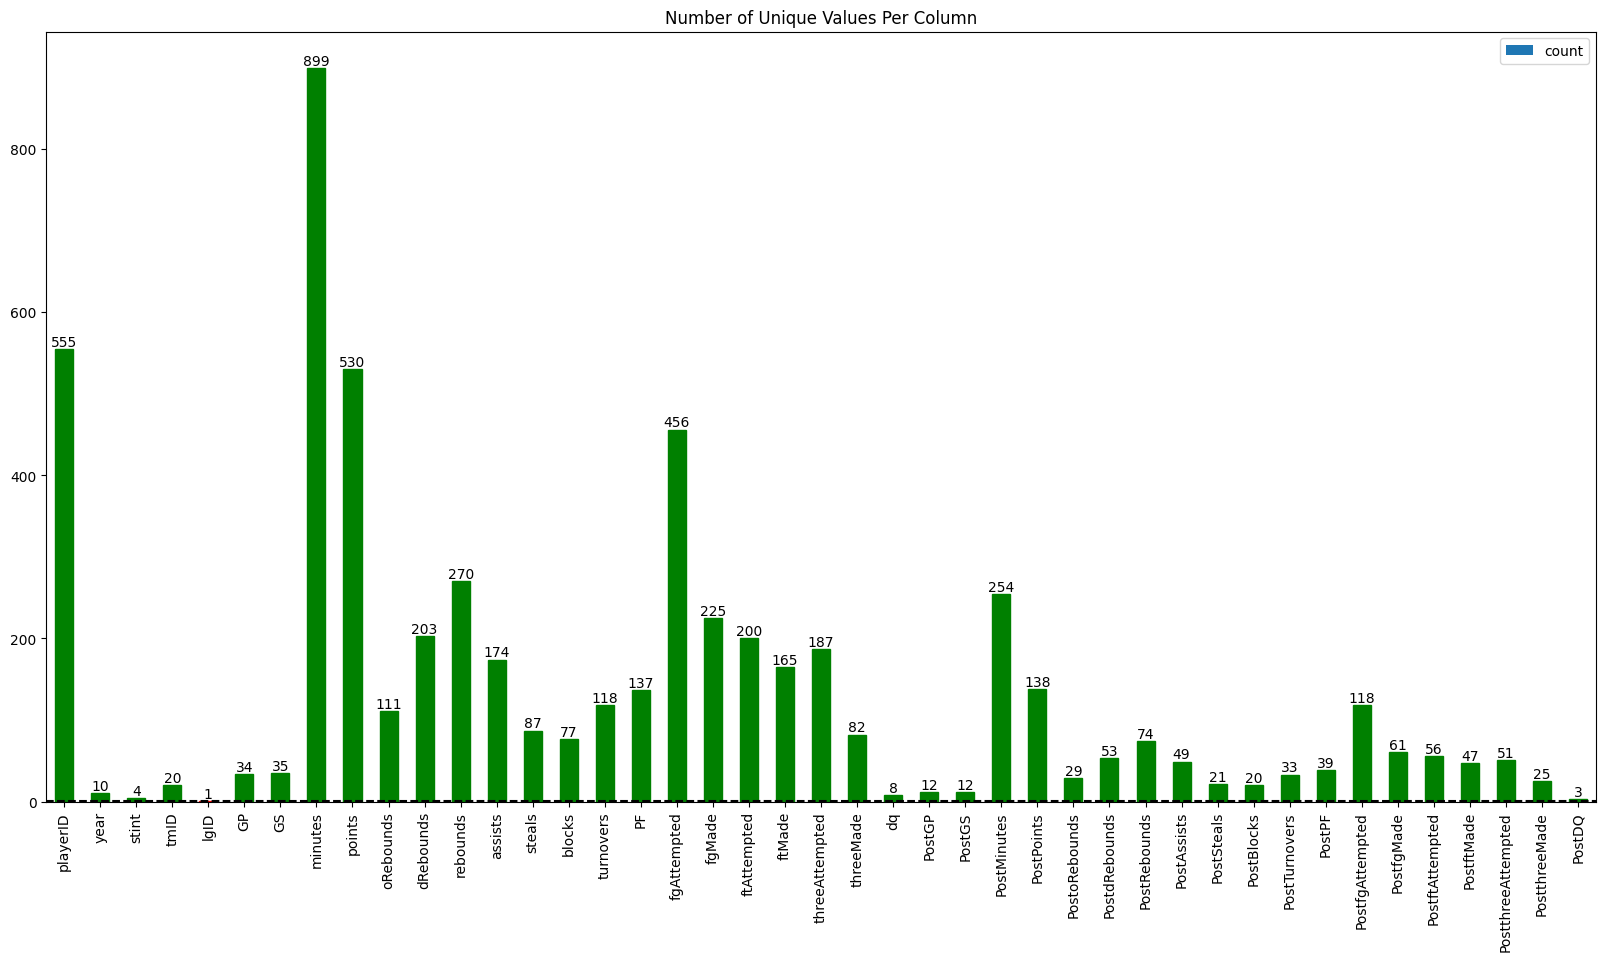

In [18]:
unique_values_by_column(df, 1, (20,10))

In [19]:
num_columns = len(df.columns)
df = filter_column_uniques(df, 1)
print(f"Removed {num_columns - len(df.columns)} columns that had only one unique value")

Removed 1 columns that had only one unique value


In [20]:
num_rows = df.shape[0]
df.drop_duplicates(inplace=True)
print(f"Removed {num_rows - df.shape[0]} repeated rows")

Removed 0 repeated rows


## Outliers and Noise

### Detecting and Removing Outliers using ...

### ... z-score

This is a simple way to detect outliers using the z-score. The z-score is the number of standard deviations away from the mean a data point is. If the absolute value of the z-score is greater than 3, we can flag this data point as an outlier.

Let's take a look at the z-score range using a histogram plot.

<module 'matplotlib.pyplot' from '/home/daniel/.local/lib/python3.10/site-packages/matplotlib/pyplot.py'>

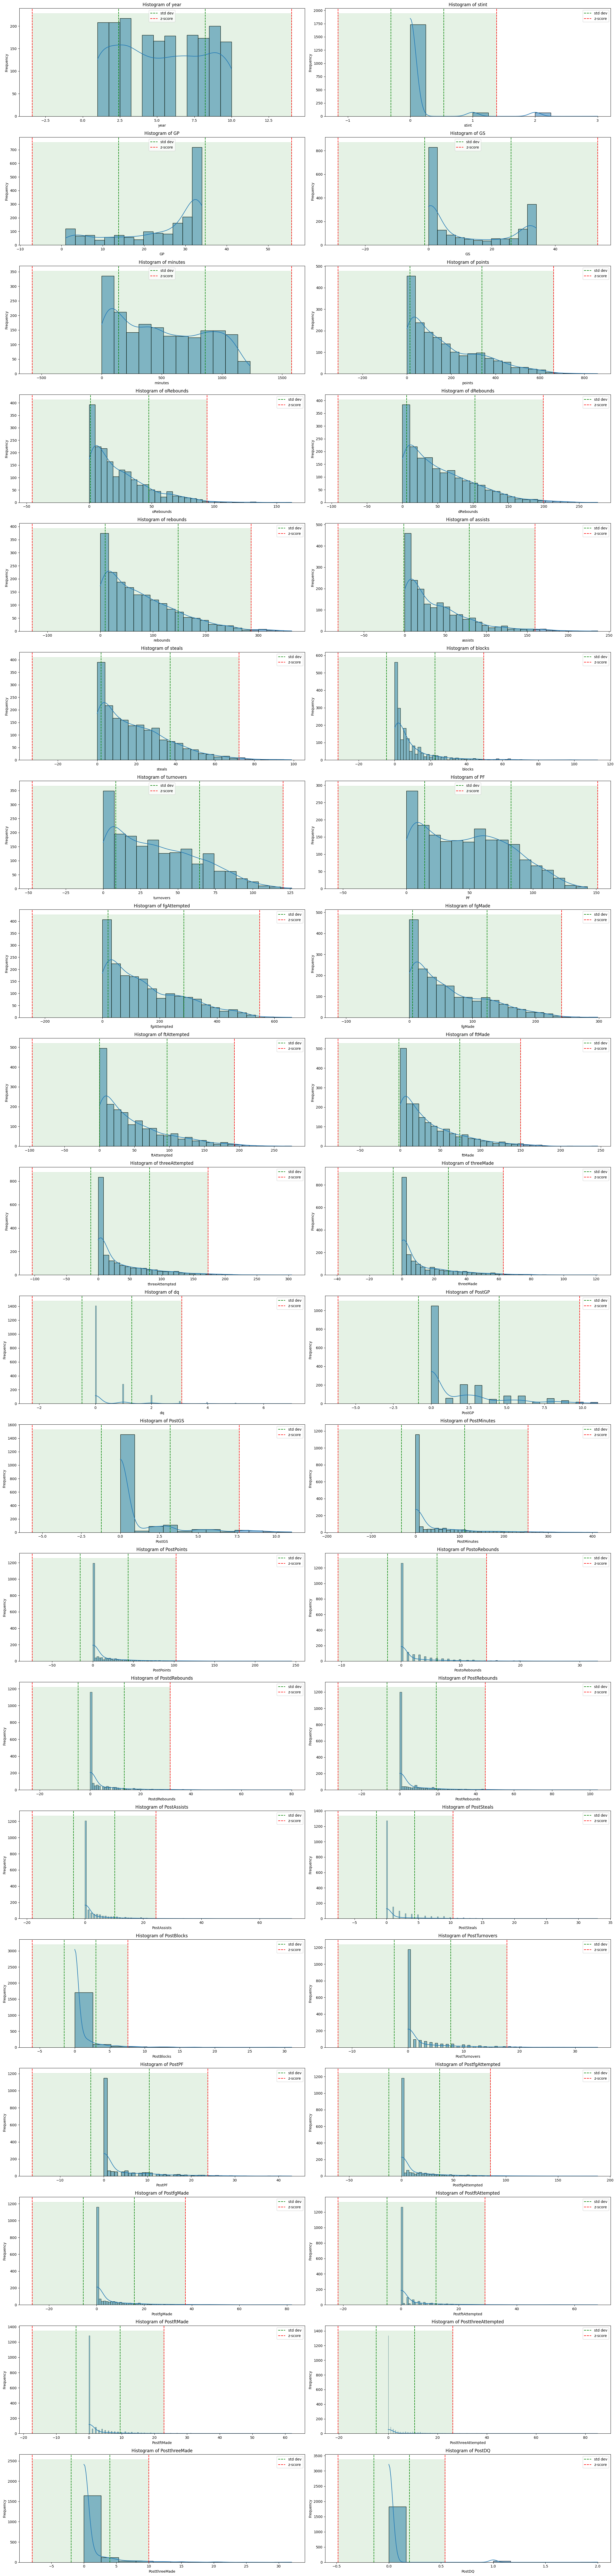

In [21]:
max_zscore = 3
rows2drop = set()
histogram_plot(df, max_zscore, (24, 100))

Now let's use the z-score to detect and remove outliers from the dataset.

In [22]:
rows2drop_zscore = filter_by_zscore(df, max_zscore)
print(f"Removed {len(rows2drop_zscore)} rows with zscore > {max_zscore}")

rows2drop.update(rows2drop_zscore)

Removed 400 rows with zscore > 3


### ... Interquartile Range (IQR)

The interquartile range (IQR) is a measure of statistical dispersion and is calculated as the difference between the 75th and 25th percentiles. It is represented by the formula IQR = Q3 − Q1. The IQR may also be called the midspread or middle 50%. It is a measure of the dispersion similar to standard deviation or variance, but is much more robust against outliers.

Let's take a look at the IQR range using a histogram plot.

<module 'matplotlib.pyplot' from '/home/daniel/.local/lib/python3.10/site-packages/matplotlib/pyplot.py'>

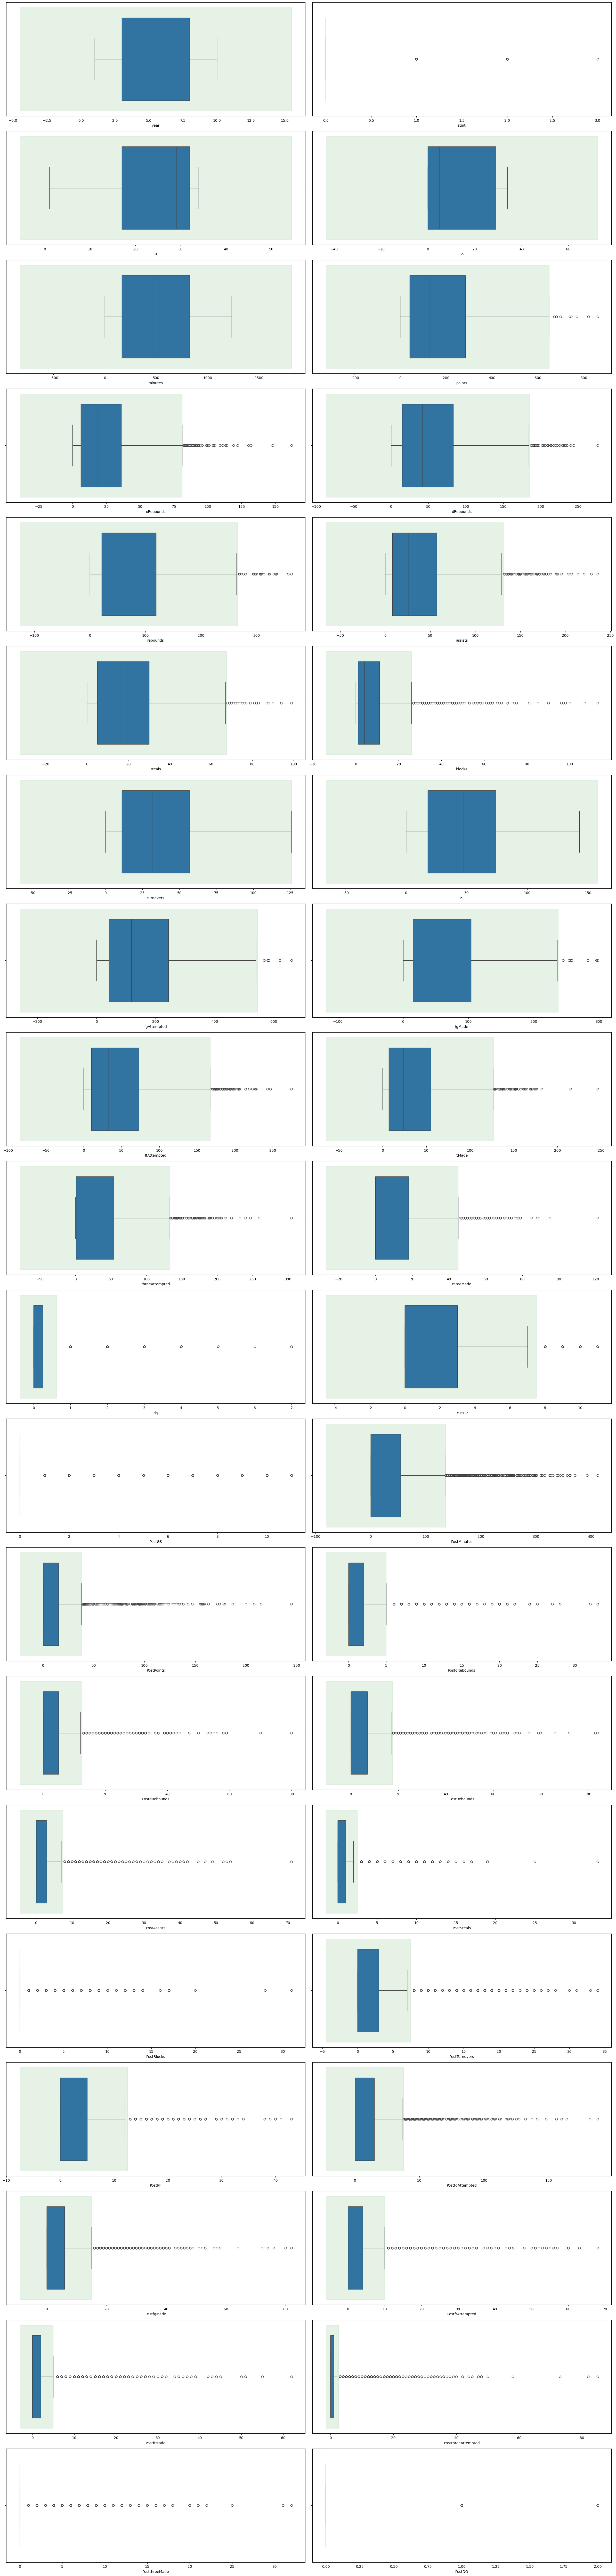

In [23]:
factor = 1.5
iqr_plot(df, factor, (24, 100))

Now let's use the IQR to detect and remove outliers from the dataset.

In [24]:
rows2drop_iqr = filter_by_iqr(df, factor)
print(f"Removed {len(rows2drop_iqr)} rows with factor = {factor}")

rows2drop.update(rows2drop_iqr)

Removed 1085 rows with factor = 1.5


### ... Scatter Plot

/home/daniel/Desktop/AC/cleaning/utils.py:178: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  fig.tight_layout()


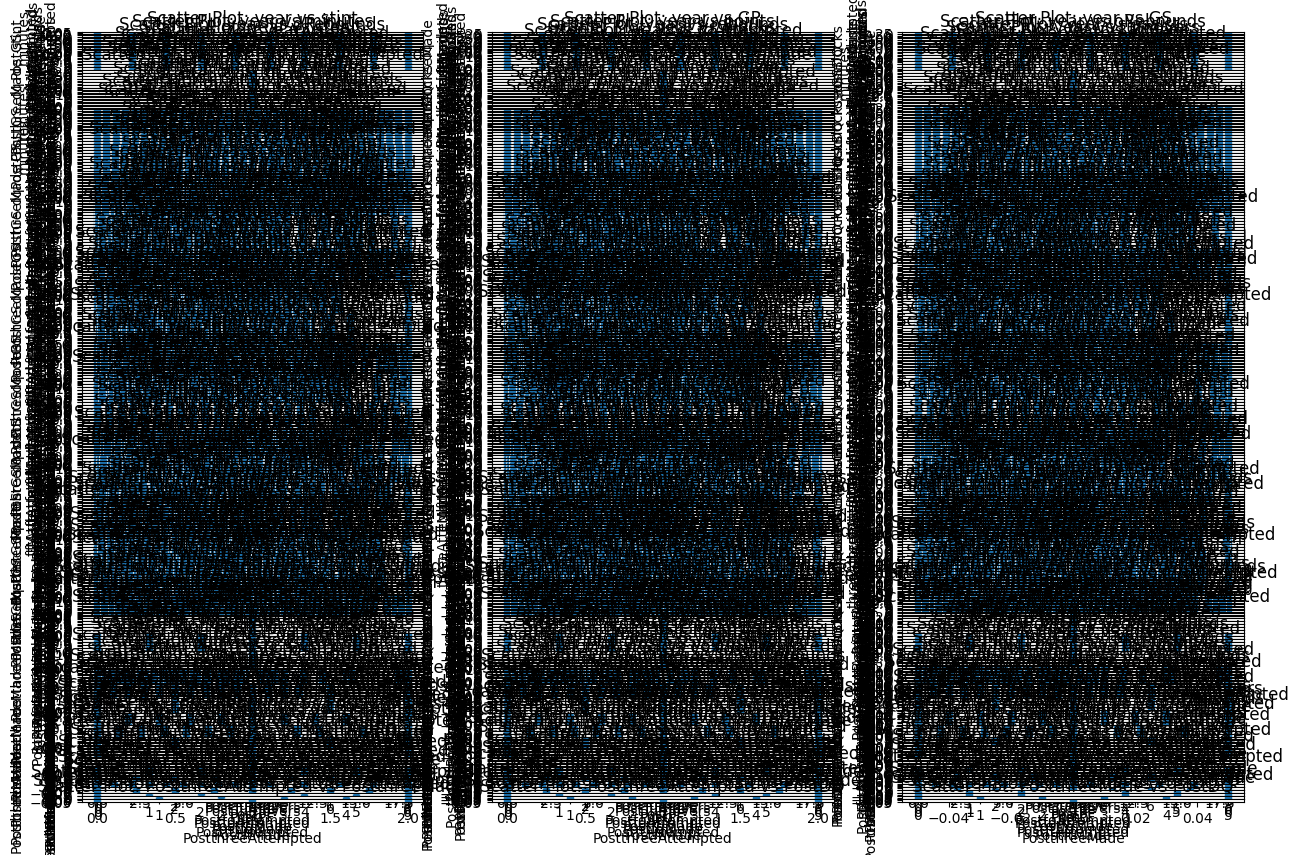

In [25]:
scatter_plot(df.drop(rows2drop))

In [26]:
print(f"Founded {len(rows2drop)} ({round(len(rows2drop) / df.shape[0] * 100, 1)}%) outliers")
#df.drop(rows2drop, axis = 0, inplace=True)
print(f"Removed {init_num_rows - df.shape[0]} rows ({round((init_num_rows - df.shape[0]) / init_num_rows * 100, 1)}%)")

Founded 1085 (57.8%) outliers
Removed 0 rows (0.0%)


## Creating CBE Feature...

In [27]:
cbe_stats = {
    'points': 1,
    'rebounds': 1,
    'assists': 1,
    'steals': 1,
    'blocks': 1,
    'turnovers': -1,
    'PF': -1}

df['CBE_Sum'] = 0

for index, row in df.iterrows():
    cbe_sum = 0
    for key in cbe_stats:
        cbe_sum += row[key] * cbe_stats[key]
    if row['minutes'] == 0:
        df['CBE_Sum'][index] = 0
    else:
        df['CBE_Sum'][index] = (cbe_sum / row['minutes'])

columns_to_keep = ['playerID', 'year', 'tmID', 'CBE_Sum']


players_teams_test = pd.read_csv('../data/test/players_teams.csv')
players_teams_test.drop(['lgID', 'stint'], axis=1, inplace=True)
players_teams_test['CBE_Sum'] = 0
df = pd.concat([df, players_teams_test], axis=0)
df.reset_index(inplace=True, drop=True)

for column in df.columns:
    if column not in columns_to_keep:
        df.drop(column, axis=1, inplace=True)

/tmp/ipykernel_18674/1367351625.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CBE_Sum'][index] = (cbe_sum / row['minutes'])
/tmp/ipykernel_18674/1367351625.py:19: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5508274231678487' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df['CBE_Sum'][index] = (cbe_sum / row['minutes'])


In [28]:
counter = 0
df.sort_values(by=['playerID', 'year'], inplace=True)
df.reset_index(inplace=True, drop=True)

def update_CBE_Sum(df, id):
    global counter
    arr = df[df['playerID'] == id]
    arr.sort_values(by=['year'], inplace=True, ascending=False)
    for i, _ in arr.iterrows():
        sum = 0
        years_arr = [x for x in arr['year'].unique() if x < arr.at[i, 'year']]
        l = len(years_arr)
        if l == 0:
            arr.at[i, 'CBE_Sum'] = 0
            continue
        factor = 1 / l
        for k in range(l):
            sum += arr.at[k + counter, 'CBE_Sum'] * factor
        print(sum)
        arr.at[i, 'CBE_Sum'] = sum
        arr.sort_values(by=['year'], inplace=True)
    counter += len(arr)
    return arr
    
    

player_ids = df['playerID'].unique()
for player_id in player_ids:
    next_season_CBE = df[df['playerID'] == player_id].tail(1)['CBE_Sum']
    arr = update_CBE_Sum(df, player_id)
    df[df['playerID'] == player_id] = arr

/tmp/ipykernel_18674/3770257153.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  arr.sort_values(by=['year'], inplace=True, ascending=False)
/tmp/ipykernel_18674/3770257153.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  arr.sort_values(by=['year'], inplace=True)


0.5051323886917354
0.4956081901284956
0.503293364065797
0.5136083395738807
0.531852966473688
0.528208742639825
0.5508274231678487
0.47773926238478287
0.478476821192053
0.2610294117647059
0.18085106382978725
0.0
0.26724535613361794
0.22106144102839878
0.20752639173691806
0.18128654970760233
0.2507002801120448
0.2857142857142857
0.29897314631248295
0.35372287736346125
0.41405269761606023
0.6617672748447205
0.5880434782608696
0.48078385050313077
0.4881695471497143
0.502415611047152
0.38178096212896623
0.3699174184797845
0.3699174184797845
0.4660529344073648
0.3756485658848361
0.3716920269094459
0.37170263788968827
0.7901012700277853
0.7594608694003429
0.7841049317396698
0.7402135231316725
0.3661708126617326
0.3733222485321298
0.39892665474060823
0.30583922492799165
0.31343283582089554
0.45418960954831294
0.48897672201477715
0.44136807817589574
0.44136807817589574
0.5367274607931123
0.5798816568047337
0.5798816568047337
0.5824980377554112
0.5712661406025825
0.5884146341463414
0.34110275689

## Save Dataset

In [29]:
if not os.path.exists('../data/clean'):
    os.makedirs('../data/clean')

df.to_csv('../data/clean/players_teams.csv', index=False)